#  Provenance integration in netcdf/xarray Data-Intensive workflows


#### Authors: Alessandro Spinuso and Andrej Mihajlovski

 
####  Royal Netherlands Meteorological Institure (KNMI)


The following "Live" notebook demonstrates a simple workflow implemented with a data-intensive processing library (dispel4py),  that has been extended with a configurable and programmable provenance tracking framework (Active provenance).

## Highligts - Active Provenance, S-PROV and S-ProvFlow
<ul>
<li>
The provenance information produced can be tuned and adapted to computational, precision and contextualisation requirements</li>
<li>
The Active freamework allows for the traceability of data-reuse across different executions, methods and users</li>
<li>The provenance can be stored as files or sent at run-time to an external repository (S-ProvFlow)</li>
<li>The repository can be searched and explored via interactive tools</li> 
<li>The provenance model is designed around an hybrid data-flow model, which takes into account data-streams and concrente data resourcese. eg. file location, webservices etc.</li>
<li>The lineage can be exported from the repository in W3C PROV format. This facilitates the production of interoperabile reports and data-curation tasks. For instance, The provenance related to specific data can be stored in W3C-PROV XML format into strucutred file formats (NetCDF) as well as istitutional and general-purpose citable data-repositories.</li>
</ul>

## Demonstration outline

### 1 - Workflow specification and execution

<ol>
  <li>Define the <i><b>Classes</b></i> of the <i><b>Workflow Components</b></i></li>
  <li>Construct the <i><b>Workflow</b></i> application</li>
  <li>Prepare the Input</li>
  <li>Visualise and run the workflow without provenance</li>
</ol>

### 2 - Provenance Types, Configuration and Contextualisation

<ol>
  <li>Define the <i><b>Provenance Types</b></i> to be used within the workflow</li>
  <li><i><b>Configure</b></i> the workfow for provenance tracking</li>
  <li>Visualise and run workfow with provenance activatied</li>
  <li>Export and embed provenance within NetCDF results</li>
  <li>Explore the resulting provenance with interactive and static visualsations</li>
</ol>

### 3 - Data-reuse traceability. 
<ol>
  <li>Change the input and demostrate consistency of provenance for data-ruse across multiple workflow executions</li>
  <li>Discuss more complex use cases and configuration options</li>
</ol>

### 4 - Informal Evaluation

SWOT form:

https://docs.google.com/presentation/d/10xlRYytR7NB9iC19T29BD-rW77ZAtnjtlukMJDP_MIs/edit?usp=sharing


## 1 - Workflow specification and execution


<ul>
<li>The dispel4py framework is utilised for the workflows</li>
<li>Xarray for in-memory management of netcdf data.</li>
<li>Matplotlib for visualisation.</li>
<li>W3C for provenance representation.</li>
</ul>

In [1]:
import xarray
#import netCDF4
import json

from dispel4py.workflow_graph import WorkflowGraph 
from dispel4py.provenance import *

from collections import OrderedDict
import time
import random

from dispel4py.base import create_iterative_chain, ConsumerPE, IterativePE, SimpleFunctionPE

import matplotlib.pyplot as plt
import traceback

from pprint import pprint

Simple Workflow, xarray in xarray out. 
The generic processing elements are defined below. the <i>GenericPE</i> bellongs to the dispel4py framework. It allows data-objects to be passed as inputs and outputs. The <i>Components</i> are linked and visualised via the workflow_graph module.

### 1.1 The Four Workflow Components:

<ol>
<li>- Read, xarray is read into memory.</li>
<li>- ANALYSIS, xarray is processed/passed to output (dummy, no real changes in the example)</li>
<li>- Write, xarray is visualised.</li>
<li>- Combine, two xarray are combined into one ds.</li>
</ol>

In [7]:


class Read(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('xarray')
        self.count=0

    def _process(self,inputs):
        self.log('Read_Process')
     
        self.log(inputs)
        
        inputLocation = inputs['input'][0]

        ds = xarray.open_dataset( inputLocation )
        
        self.write( 'xarray' , (ds, self.count) , location=inputLocation )
        self.count+=1
            
class Write(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('location')
        self.count=0
         
         
        
    def _process(self,inputs):
        self.log('Write_Function')
        #self.log(inputs)
        outputLocation = "data/new_"+str(self.count)+".nc"
        self.count+=1
        inputs['input'][0].to_netcdf( outputLocation )
        #self.log(outputLocation)
        self.write('location', outputLocation,location=outputLocation)
        
        
        
class Analysis(GenericPE):
        
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('output')
         
        
    def _process(self,inputs):
        #self.log('Workflow_process')
        #self.log( len(inputs))
        
        #nc = inputs['input'][0]
        self.parameters=[]
        nc = inputs['input'][0]
        #self.log(nc)
        #
        self.write('output', (nc,inputs['input'][1]),metadata={'prov:type':'clipc:sum','index':inputs['input'][1]},message="")
        
        


class Combine(GenericPE):
     
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('combine1',grouping=[1])
        self._add_input('combine2',grouping=[1])
        self._add_output('combo')
        self.count=0
        self.data1=[]
        self.data2=[]
        self.nc1 = None
        self.nc2 = None
        self.out = None
        
    def _process(self,inputs):
        self.log('Combine_process')
        self.log(inputs.keys())
        
        if 'combine1' in inputs.keys():
            self.data1.append(inputs['combine1'][0])
            
        
        if 'combine2' in inputs.keys():
            self.data2.append(inputs['combine2'][0])
            
        
        
        if (len(self.data1)>0 and len(self.data2)>0):
            #self.log("LEN"+str(len(self.data1)))
            nc1 =  self.data1.pop(0)
            nc2 =  self.data2.pop(0)
            
            nc=nc1
            # numpy arithmetic for DataArrays...
             
            #self.log(nc2)
            for k,v in nc2.attrs.items():
                if k in nc.attrs.keys():
                    nc.attrs[k] = v
                else:
                    nc.attrs[k] = v
            
           
            
            self.write('combo', (nc,self.count))
            self.count+=1



### 1.2 Construct the Workflow application

Instantiates the Components and combines them in a workflow graph which gets eventually visualised.

Siz Instances are created from the above PEs.

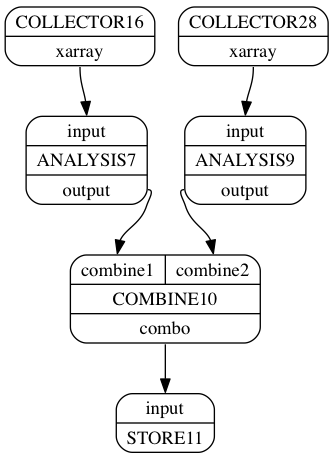

In [8]:

#Initialise the graph
def createWorkflowGraph():
    readX  = Read()
    readX.name = 'COLLECTOR1'
    readY  = Read()
    readY.name = 'COLLECTOR2'
    
    analyse   = Analysis()
    analyse.name    = 'ANALYSIS'
    analyse.parameters = { 'filter': 10 }

    analyse2   = Analysis()
    analyse2.name    = 'ANALYSIS'
    analyse2.parameters = { 'filter': 13 }
    
    wf3     = Combine()
    wf3.name    = 'COMBINE'
    wf3.parameters = { 'wf':'paramC' }
    
    writeX = Write()
    writeX.name = 'STORE'
    
    
    graph = WorkflowGraph()    
    
    graph.connect(readX ,'xarray'   , analyse      ,'input')
    graph.connect(readY ,'xarray'   , analyse2     ,'input')
    
    graph.connect( analyse  ,'output'   , wf3     ,'combine1')
    graph.connect( analyse2 ,'output'   , wf3     ,'combine2')
    
    graph.connect(wf3    ,'combo'   , writeX , 'input')

    return graph



graph = createWorkflowGraph()


from dispel4py.visualisation import display
display(graph)




### 1.3 Specify the Input

A simple json representation is used to define initial input data for each named Component of the workflow.
Every component can recieve a list of inputs. These will be streamed serially or in parallel, depending from the execution mode

In [9]:
name="new"

input_data = {     
                'COLLECTOR1': [ { 'input' : [ 'http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc']},
                               { 'input' : [ 'http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc']}],
                'COLLECTOR2': [ { 'input' : [ 'http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc']},
                               { 'input' : [ 'http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc']}]
                #'COLLECTOR': [ { 'input': [ 'data/new_1.nc']}],
                #'COLLECTOR2': [ { 'input': [ 'data/newA.nc']}]
             }



### 1.3 Run the Workflow



In [10]:

def runExampleWorkflow():
                                                     
    print input_data                   

    #Launch in simple process
    result = simple_process.process_and_return(graph, input_data)
    print "\n RESULT: "+str(result)


In [11]:
runExampleWorkflow()

{'COLLECTOR1': [{'input': ['http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc']}, {'input': ['http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc']}], 'COLLECTOR2': [{'input': ['http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc']}, {'input': ['http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc']}]}
COLLECTOR16: Read_Process
COLLECTOR16: {'input': ['http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc']}
COLLECTOR16: Read_Process
COLLECTOR16: {'input': ['http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_1979100

## 2 - Provenance Types, Configuration and Contextualisation

### 2.1 Define a Provenance Type

Once the Provenance types have been defined, these are used to configure, or configure a workflow execution to comply with the desired provenance collection requirements.  Below we illustrate the framework method and the details of this approach.

<ul>

<li><b><i>configure_prov_run</i></b> With this method, the users of the workflow can configure their run for provenance by indicating which types to apply to each component. Users can also chose where to store the metadata, locally to the file system or to a remote service. These operations can be performed in bulks, with different impacts on the overall overhead and on the experienced rapidity of the access of the lineage information. Finally, also general information about the attribution of the run, such as <i>username, run_id, description, workflow_name, workflow_id</i> are captured and included within the provenance traces.
</li>
<li><b><i>applyFlowResetPolicy (Advanced)</i></b>
This method is invoked by each iteration when a decision has to be made on the required lineage pattern. The framework automatically passes information whether the invocation has produced any output or not. The method, according to predefined rules, provides indications on either discarding the current input data or to include it into the <i>StateCollection</i> automatically, capturing its contribution to the next invocation. 
In our implementation, basic provenance types such are available and can be used accordingly the specific needs.
</li>
<li><b><i>Selectiviy-Rules (Advanced)</i></b>
Users can tune the scale of the records produced by indicating in the above method a set of <i>Selectiviy-Rules</i> for every component. This functionality allows users to specify rules to control the data-driven production of the provenance declaratively. The approach takes advantage of the contextualisation applied by the provenance types, which extract domain and experimental metadata, and evaluates their value against simple <i>Selectiviy-Rules</i>
</li>
</ul>

Type for contextual metadata in netcdf:

<b>netcdfProvType</b>: applicable to components that deal with a data formats containing array-oriented scientific data, including multiple variables and attributes associated with standard vocabularies and uid schemas.

Type capturing provenance patterns:

<b>Nby1Flow:</b> manges lineage of a component whose output depends on the data received on all its input ports in
lock-step; e.g. combined analysis of multiple variables



In [14]:
class netcdfProvType(ProvenanceType):
    def __init__(self):
        ProvenanceType.__init__(self)
        self.addNamespacePrefix("clipc","http://clipc.eu/ns/#")
    
    def extractDataSourceId(self,data, input_port):
        #Extract here the id from the data (type specific):

        self.log('ANDREJ.extractExternalInputDataId')
         
        
        try:
             
            ds = xarray.open_dataset(data[0])
            id = ds.attrs['id']
             
             
            
            
        except Exception, err:
            id = str(uuid.uuid1())
             
       
        return id
     
    
    def makeUniqueId(self, data, output_port):      
        
        #self.log('ANDREJ.makeUniqueId')
        
        #produce the id
        id=str(uuid.uuid1())
            
        ''' if nc data '''
        if data!=None:
            xa = data[0]
        
            ''' unique as defined by the community standard '''
            xa.attrs['id'] = id
        
        #Return
        return id 
    

    
    ''' extracts xarray metadata '''
    def extractItemMetadata(self, data, output_port):
         
        
        try:            
            nc_meta = OrderedDict()
            
            ''' cycle throug all attributes, dimensions and variables '''
            xa = data[0]
            # dataset meta
            nc_meta['Dimensions'] = str( dict(xa.dims)) 
            nc_meta['Type'] = str(type(xa))
            
             
            for n , i in xa.data_vars.items():
                for k , v in i.attrs.items():
                    nc_meta['clipc:'+n+"_"+str(k).replace(".","_")] = str(v)[0:25]
            
           
            metadata = [nc_meta]
            
            return metadata
                             
        except Exception, err:
            self.log("Applying default metadata extraction"+str(traceback.format_exc()))
            self.error=self.error+"Applying default metadata extraction:"+str(traceback.format_exc())
            return super(netcdfProvType, self).extractItemMetadata(data,output_port);
        
        
        
class Nby1Flow(ProvenanceType):
    def __init__(self):
        ProvenanceType.__init__(self)
        self.ports_lookups={}
        

    def apply_derivation_rule(self,event,voidInvocation,oport=None,data=None,iport=None,metadata=None):
    
         

        if (event=='write'):
            dep=[]
            for x in self.inputconnections:
                if x!=iport and x!='_d4py_feedback':
                    vv=self.ports_lookups[x].pop(0)
                    dep.append(vv)
                    #self.log("LOOKUP: "+str(vv))
                self.setStateDerivations(dep)
                

        if (event=='end_invocation_event' and voidInvocation==True):
                
            if data!=None:
                #self.ports_lookups['iport'].append(vv)
                vv=str(abs(make_hash(tuple(iport+str(self.iterationIndex)))))
                if not (iport in self.ports_lookups):
                    self.ports_lookups[iport]=[]

                self.ports_lookups[iport].append(vv)
                #self.log(self.ports_lookups)
                #self.ignorePastFlow()
                self.update_prov_state(vv,None,metadata={"LOOKUP":str(vv)})
                self.discardInFlow()


        if (event=='end_invocation_event' and voidInvocation==False):
                 self.discardInFlow()
                 self.discardState()

        

The 'configuration' describing the provenance setup.

In [15]:
prov_config =  {
                    'provone:User': "aspinuso", 
                    's-prov:description' : "provdemo combo double",
                    's-prov:workflowName': "demo_ecmwf",
                    's-prov:workflowType': "clipc:combine",
                    's-prov:workflowId'  : "workflow process",
                    's-prov:save-mode'   : 'service'         ,
                    # defines the Provenance Types and Provenance Clusters for the Workflow Components
                    's-prov:componentsType' : 
                                       {'ANALYSIS': {'s-prov:type':(netcdfProvType,),
                                                     's-prov:prov-cluster':'clipc:Combiner'},
                                        'COMBINE':  {'s-prov:type':(netcdfProvType, Nby1Flow,),
                                                     's-prov:prov-cluster':'clipc:Combiner'},
                                        'COLLECTOR1':{'s-prov:prov-cluster':'clipc:DataHandler,',
                                                     's-prov:type':(netcdfProvType,)},
                                        'COLLECTOR2':{'s-prov:prov-cluster':'clipc:DataHandler,',
                                                     's-prov:type':(netcdfProvType,)},
                                        'STORE':    {'s-prov:prov-cluster':'clipc:DataHandler'}
                                        },
                    's-prov:sel-rules': None
                } 


The REPOS_URL is the target provenence repo.

In [16]:
#Store via service
ProvenanceType.REPOS_URL='http://ec2-18-197-219-251.eu-central-1.compute.amazonaws.com/workflowexecutions/insert'
ProvenanceType.PROV_EXPORT_URL='http://ec2-18-197-219-251.eu-central-1.compute.amazonaws.com/data/'


#Store to local path
ProvenanceType.PROV_PATH='./prov-files/'

#Size of the provenance bulk before sent to storage or sensor
ProvenanceType.BULK_SIZE=3

#ProvenancePE.REPOS_URL='http://climate4impact.eu/prov/workflow/insert'


Change grouping implementation 
ANALYSIS Original base class: (<class 'dispel4py.core.GenericPE'>,)
 New type: (<class '__main__.netcdfProvType'>, <class '__main__.Analysis'>)
ANALYSIS Original base class: (<class 'dispel4py.core.GenericPE'>,)
 New type: (<class '__main__.netcdfProvType'>, <class '__main__.Analysis'>)
COLLECTOR1 Original base class: (<class 'dispel4py.core.GenericPE'>,)
 New type: (<class '__main__.netcdfProvType'>, <class '__main__.Read'>)
COLLECTOR2 Original base class: (<class 'dispel4py.core.GenericPE'>,)
 New type: (<class '__main__.netcdfProvType'>, <class '__main__.Read'>)
COMBINE Original base class: (<class 'dispel4py.core.GenericPE'>,)
 New type: (<class '__main__.netcdfProvType'>, <class '__main__.Nby1Flow'>, <class '__main__.Combine'>)
STORE Original base class: (<class 'dispel4py.core.GenericPE'>,)
 New type: (<class 'dispel4py.provenance.ProvenanceType'>, <class '__main__.Write'>)
Inputs: {'NewWorkflowRun': [{'input': 'None'}]}
NewWorkflowRun18: BUILDING 

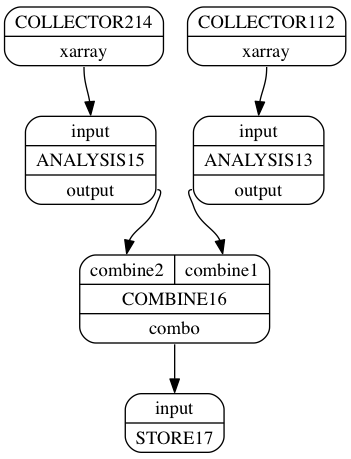

In [17]:
def createGraphWithProv():
    
    graph=createWorkflowGraph()
    #Location of the remote repository for runtime updates of the lineage traces. Shared among ProvenanceRecorder subtypes

    # Ranomdly generated unique identifier for the current run
    rid='JUP_COMBINE_'+getUniqueId()

    
    # Finally, provenance enhanced graph is prepared:
    

     
    #Initialise provenance storage to service:
    configure_prov_run(graph, 
                     provImpClass=(ProvenanceType,),
                     username=prov_config['provone:User'],
                     runId=rid,
                     description=prov_config['s-prov:description'],
                     workflowName=prov_config['s-prov:workflowName'],
                     workflowType=prov_config['s-prov:workflowType'],
                     workflowId=prov_config['s-prov:workflowId'],
                     save_mode=prov_config['s-prov:save-mode'],
                     componentsType=prov_config['s-prov:componentsType']
                      
                    )
    
    return graph


graph=createGraphWithProv()

display(graph)

### Execution with provenance
The following script executes the workflow in single-process mode
<br/>

In [18]:
runExampleWorkflow()

{'COLLECTOR1': [{'input': ['http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc']}, {'input': ['http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc']}], 'COLLECTOR2': [{'input': ['http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc']}, {'input': ['http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc']}]}
COLLECTOR112: ANDREJ.extractExternalInputDataId
COLLECTOR112: BUILDING INITIAL DERIVATION
COLLECTOR112: Read_Process
COLLECTOR112: {'input': ['http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc']}
COLLECTOR112: ANDREJ.extractExternalInputDataId
COLLECTOR112: BUILDING I

### 2.3 - Visualise Provenance Trace

Read the if of the output to locate the provenance trace on the remote service

#### 2.3.1 Visualise in S-ProvFlow

The following link opens a local installation of the S-ProvFlow System GUI

http://localhost:8180/provenance-explorer/html/view.jsp

#### 2.3.1 Extract from S-ProvFlow API 

The following scripts extracts the provenance of the last file produced in standard PROV-XML, and embed it into the  file itself

Extraction from the API

In [19]:
#''' read id of output to locate prov '''

finalFile = 'data/new_'+str(len(input_data['COLLECTOR1'])-1)+'.nc'
from shutil import copyfile

#copyfile(finalFile, 'data/newA.nc')
ds = xarray.open_dataset(finalFile)
dataid = ds.attrs['id']     #"orfeus-as-73355-c381c282-d422-11e6-ac42-f45c89acf865"
 
print("Extract Trace for dataid: "+dataid)
expurl = urlparse(ProvenanceType.PROV_EXPORT_URL)
connection = httplib.HTTPConnection(expurl.netloc)
url="http://"+expurl.netloc+expurl.path+dataid+"/export?level=100&format=xml"
print(url)
connection.request(
                "GET", url)
response = connection.getresponse()
print("progress: " + str((response.status, response.reason)))
prov1 = response.read()
print('PROV TO EMBED:')
print str(prov1)



Extract Trace for dataid: 63a3becc-a61e-11e8-95c7-f45c89acf865
http://ec2-18-197-219-251.eu-central-1.compute.amazonaws.com/data/63a3becc-a61e-11e8-95c7-f45c89acf865/export?level=100&format=xml
progress: (200, 'OK')
PROV TO EMBED:
<?xml version='1.0' encoding='ASCII'?>
<prov:document xmlns:clipc="http://clipc.eu/ns/#" xmlns:dcterms="http://purl.org/dc/terms/" xmlns:knmi="http://knmi.nl/ns/#" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:s-prov="http://s-prov/ns/#" xmlns:var="http://schema.org#" xmlns:vcard="http://www.w3.org/2006/vcard/ns" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
  <prov:entity prov:id="var:102bc2c18615-29-78d562be-a61e-11e8-9038-0242ac110003">
    <prov:type xsi:type="xsd:QName">s-prov:WFDataTraceBundle</prov:type>
  </prov:entity>
  <prov:agent prov:id="knmi:ag_anonymous">
    <dcterms:creator>anonymous</dcterms:creator>
  </prov:agent>
  <prov:wasAttributedTo>
    <prov:entity prov:ref="var:102bc2c18615-29-7

Embed the PROV document in the NetCDF file within the 'prov_xml'of the 'provenance' property and print the file's properties

In [20]:
#ds. create variable save to file

ds.load()
ds['provenance'] = xarray.DataArray("")

ds['provenance'].attrs['prov_xml']=str(prov1)

ds.to_netcdf(str(finalFile+"_PROV"))
ds = xarray.open_dataset(str(finalFile+"_PROV"))
print ds


<xarray.Dataset>
Dimensions:                       (bnds: 2, time: 12, x: 721, y: 721)
Coordinates:
  * y                             (y) float64 -9.024e+06 -8.999e+06 ...
  * x                             (x) float64 -9.024e+06 -8.999e+06 ...
  * time                          (time) datetime64[ns] 1994-10-16T12:00:00 ...
  * bnds                          (bnds) int64 0 1
Data variables:
    time_bnds                     (time, bnds) datetime64[ns] 1979-10-01 ...
    lambert_azimuthal_equal_area  |S64 ''
    SWE                           (time, y, x) float64 nan nan nan nan nan ...
    lat                           (y, x) float64 nan nan nan nan nan nan nan ...
    lon                           (y, x) float64 nan nan nan nan nan nan nan ...
    provenance                    |S1 ''
Attributes:
    source: SMMR L3 brightness temperatures in EASE grid, ECMWF weather station data
    auxiliary_data: GLC-2000 derived land classification mask v2.0, ETOPO-5 derived mountain mask v2.0, GLC-200

Visualise the PROV document in its standard graphical view

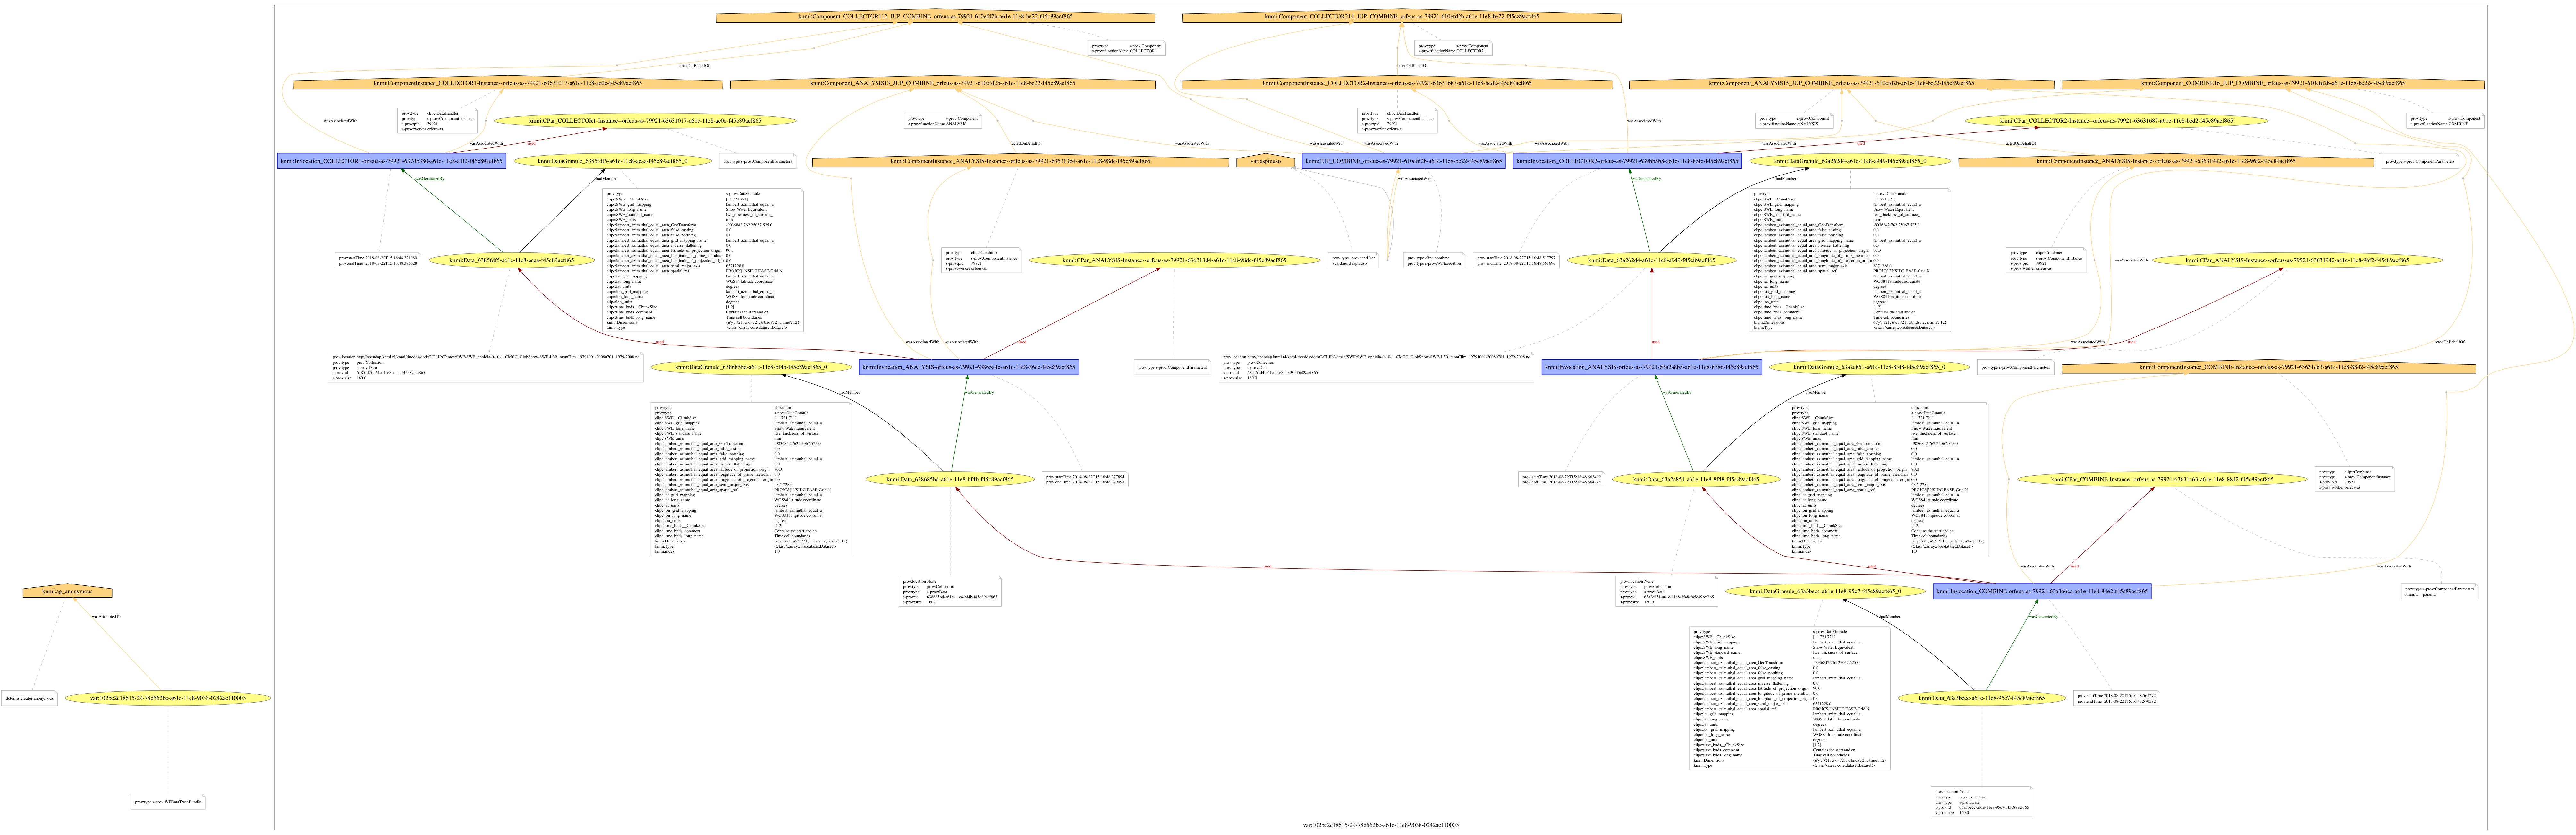

In [21]:
import prov
import io
import StringIO
from prov.model import ProvDocument, ProvBundle, ProvException, first, Literal
from prov.dot import prov_to_dot

def provTo(xml,output_f):
     
    xml_doc = StringIO.StringIO()
    xml_doc.write(str(xml))
    xml_doc.seek(0, 0)
    #print xml_doc
    doc=ProvDocument.deserialize(xml_doc,format="xml")
    dot = prov_to_dot(doc)
    return dot.create(format=output_f)


png_content=provTo(prov1,"png")

with open("PROV.png","w+") as text_file:
    text_file.write(str(png_content))

from IPython.display import Image
Image("PROV.png")

    
    
# visualse NetCDF provenance in PNG


#### Storage into generic archives

The PROV Document can be store within generic archives:

https://provenance.ecs.soton.ac.uk/store/


An example of the above W3C prov xml can be viewed using:

http://climate4impact.eu/provenance-explorer/html/view.jsp



In [ ]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs


out = ds.vDTR.isel(time=0)

ax = plt.axes(projection=ccrs.Orthographic(45, 45))
ax.set_global()
out.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

plt.show()

the end.